In [1]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import os
import sys
from datetime import datetime as dt
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import time
import matplotlib.pyplot as plt
import numpy as np
#uhuh
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import matplotlib.ticker as ticker
#uhuh
import copy
from static_helpers import *

register_matplotlib_converters()
start = time.time()

# folder of files
path = "10 Year Revision Data"
plotPath = "figures"
startDatePath = "creation/creation_dates.csv"

directories = ["figures"]

create_directories(directories)

# working list of Wiki pages
titles = get_titles()

titles = add_revision_talk_pages(titles)

titles = [add_file_extension(title) for title in titles]
titleArray = []
for title in titles:
    titleArray.append(title)



dataDict = dict()
startDateDict = dict()

for f in titleArray:
    dataDict[f[:-4]] = pd.read_csv(os.path.join(path, f))
#print(dataDict.keys())

# Dictionary to hold article start dates. Article title is the key, start date is value.
file = pd.read_csv(os.path.join(startDatePath))
for title, startDay in zip(file['Titles'], file['Page Creation Date']):
    startDay = dt.strptime(startDay, "%Y-%m-%dT%H:%M:%SZ").date()
    startDateDict[title] = startDay

allData = []
allRed = []
for key in dataDict.keys():
    if ("Data" in key):
        allData.append(dataDict[key])
    else:
        allRed.append(dataDict[key])


# Convert date to Unix Timestamp
# We convert it back to a datetime object later. 
# TODO: See if it's necessary to have this first conversion
startDate = int(time.mktime(dt.strptime("2009-12-10", "%Y-%m-%d").timetuple()))
endDate = int(time.mktime(dt.strptime("2019-12-10", "%Y-%m-%d").timetuple()))
today = int(time.mktime(dt.today().timetuple()))
# Assertions for proper date args
assert(startDate <= endDate)
assert(endDate <= today)

In [2]:
topTenEditorSet = set()
for title in titleArray[:10]:
    key = title[:-4]
    if key[0:4]!="Talk":
        article = dataDict[key]
        for user in article['user']:
            topTenEditorSet.add(user)

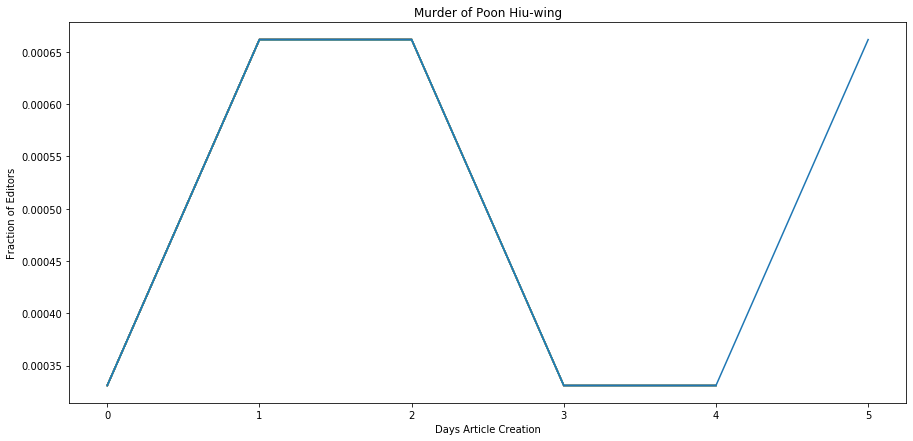

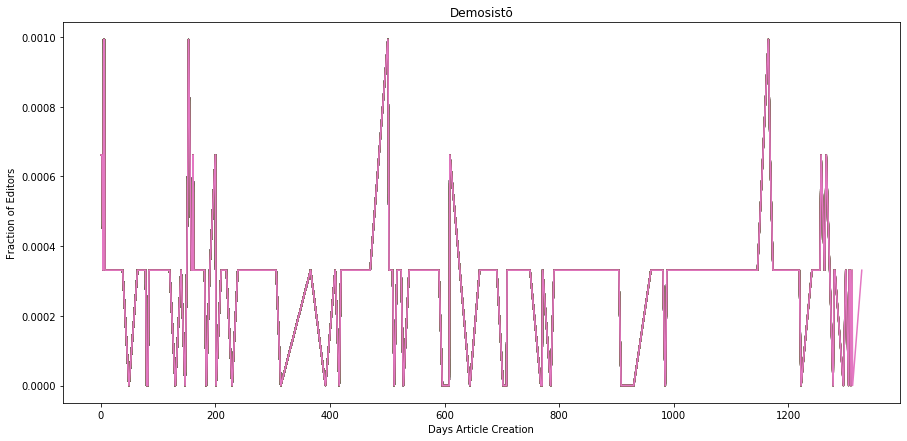

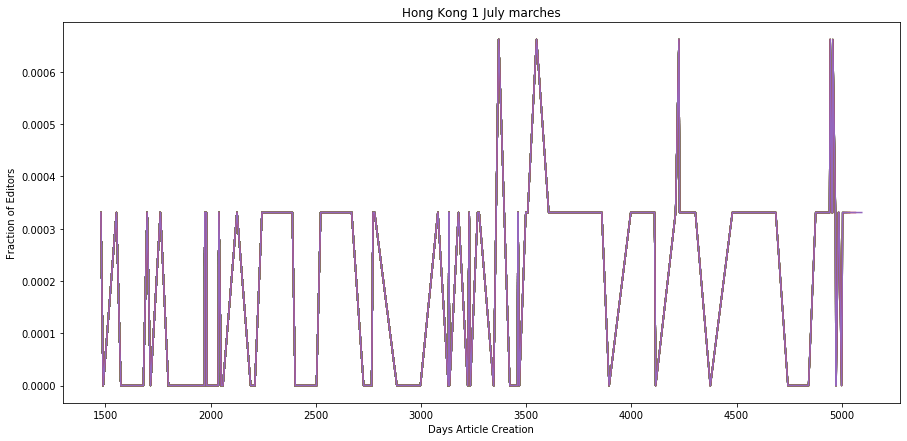

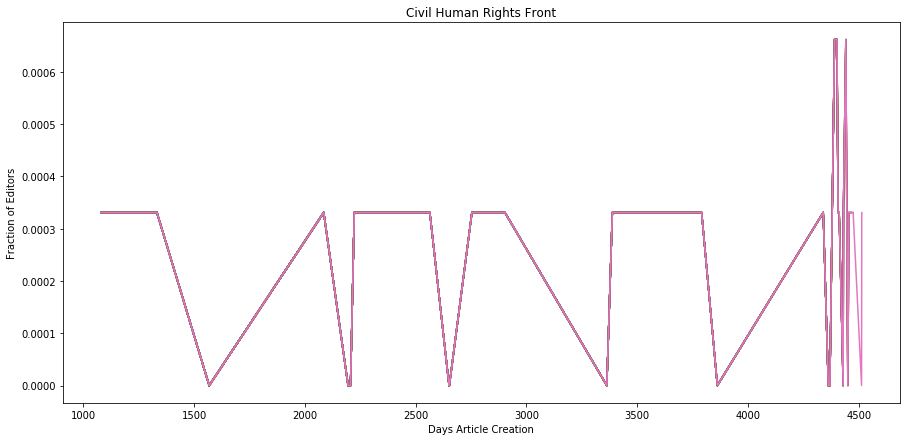

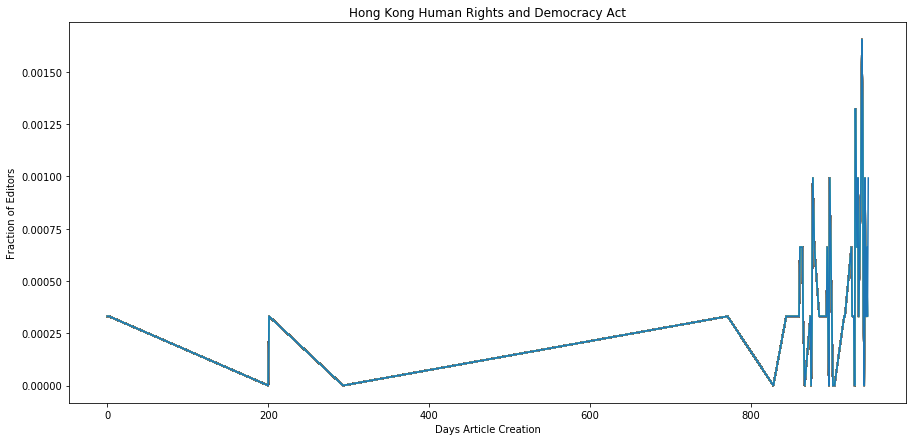

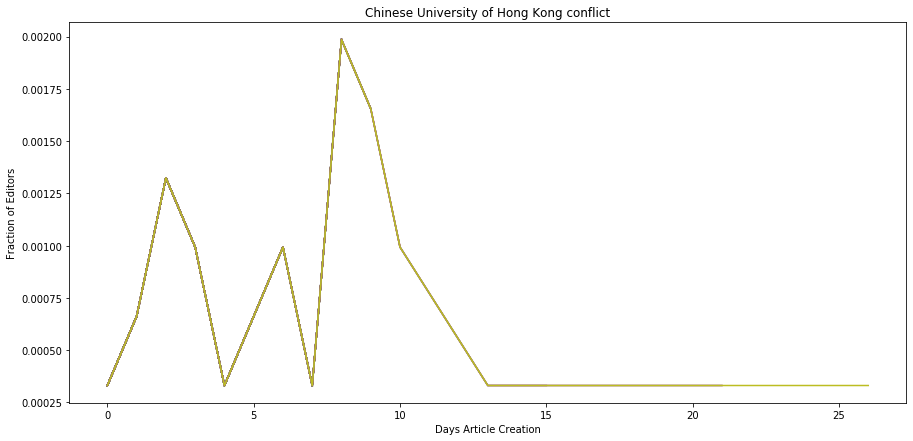

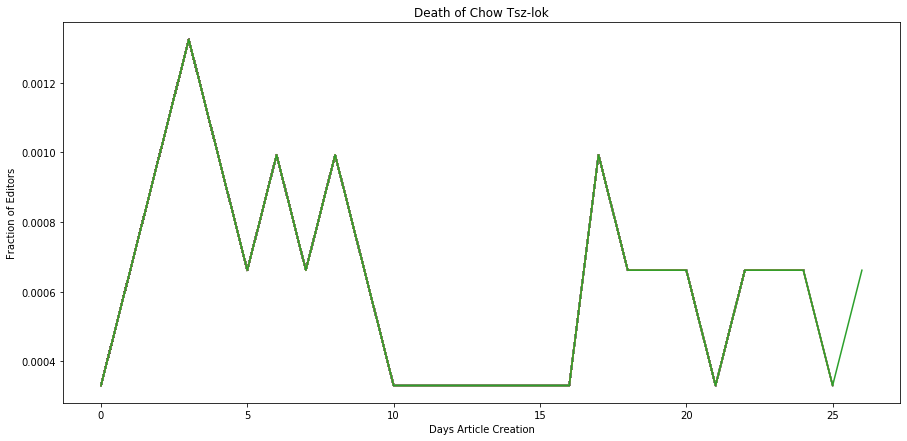

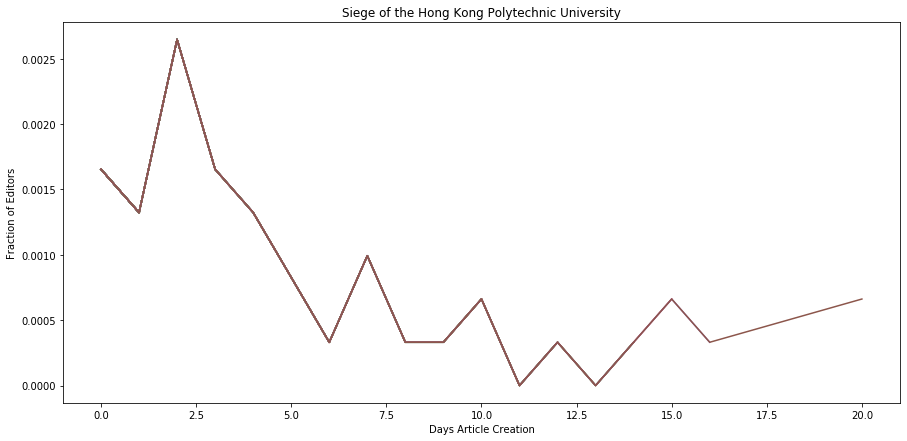

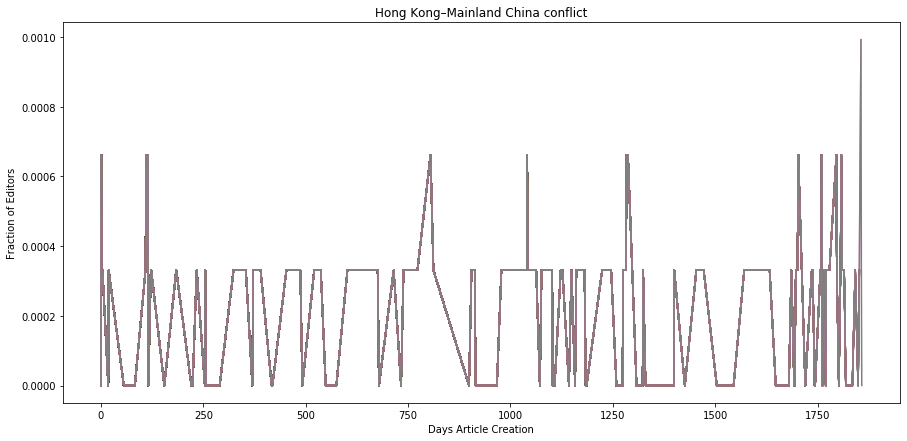

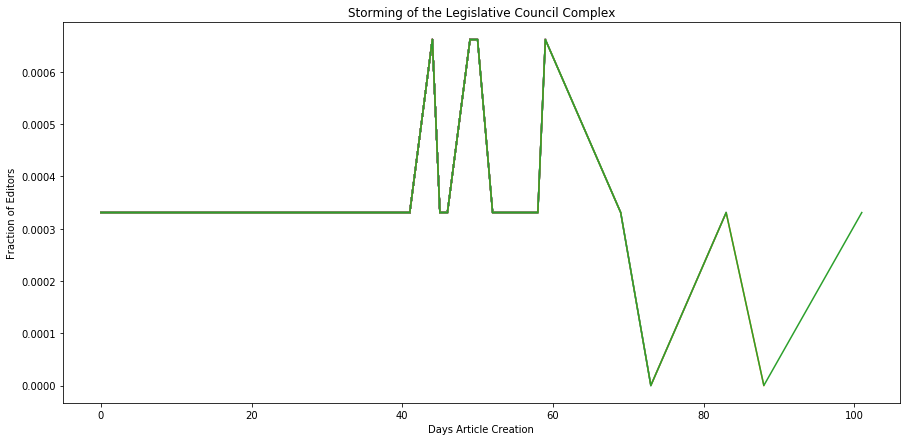

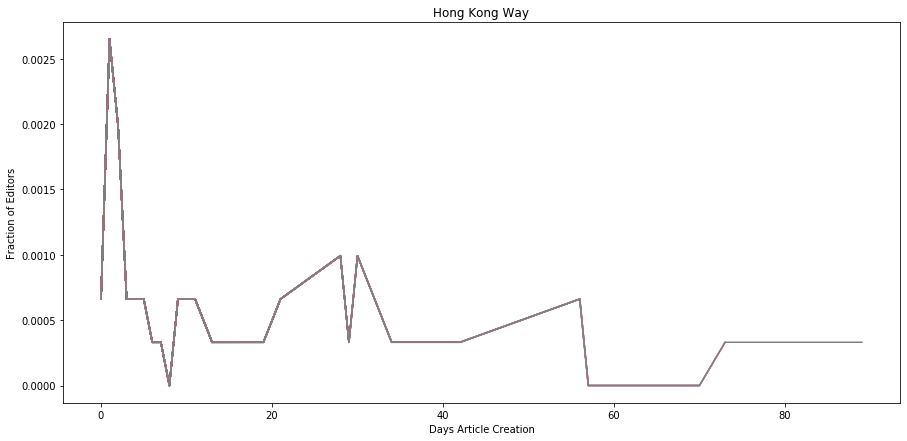

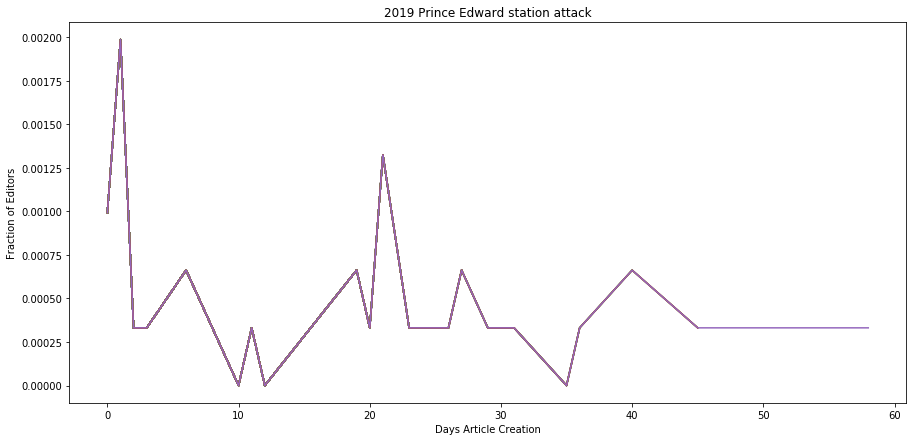

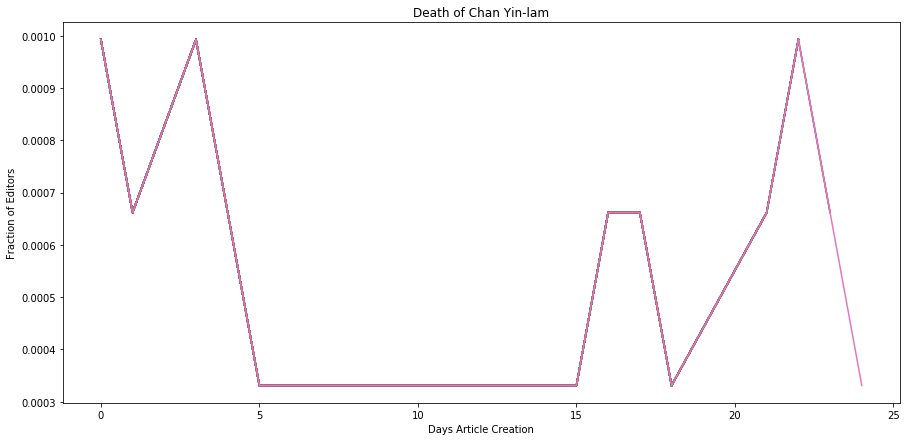

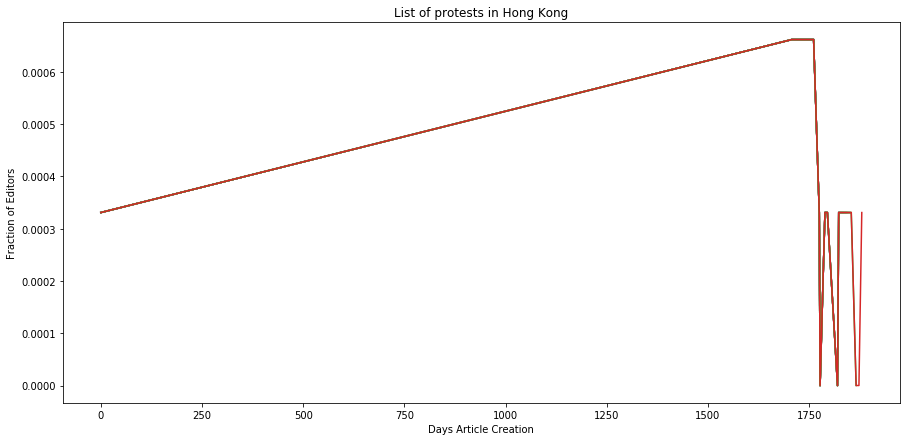

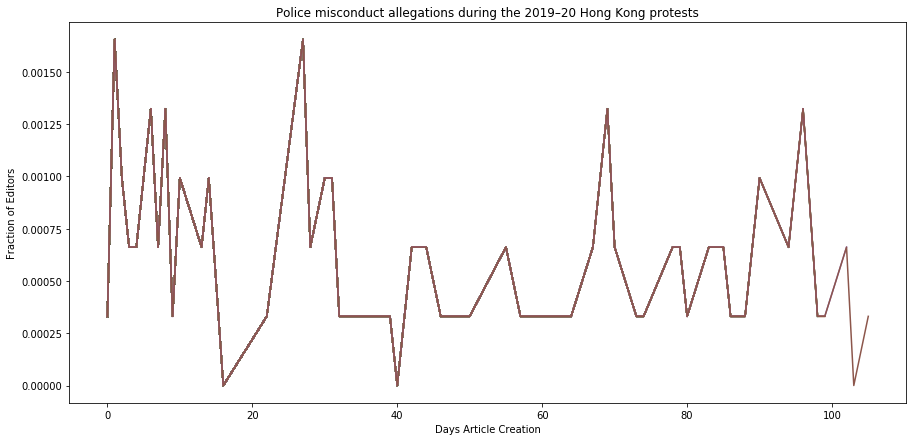

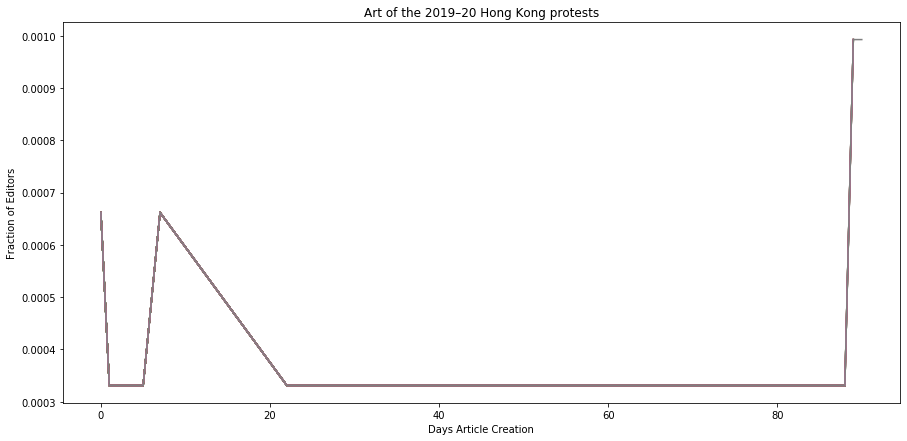

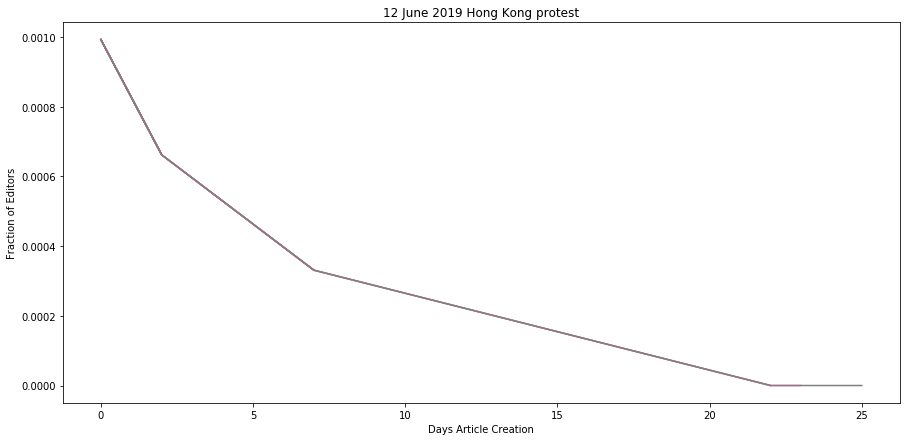

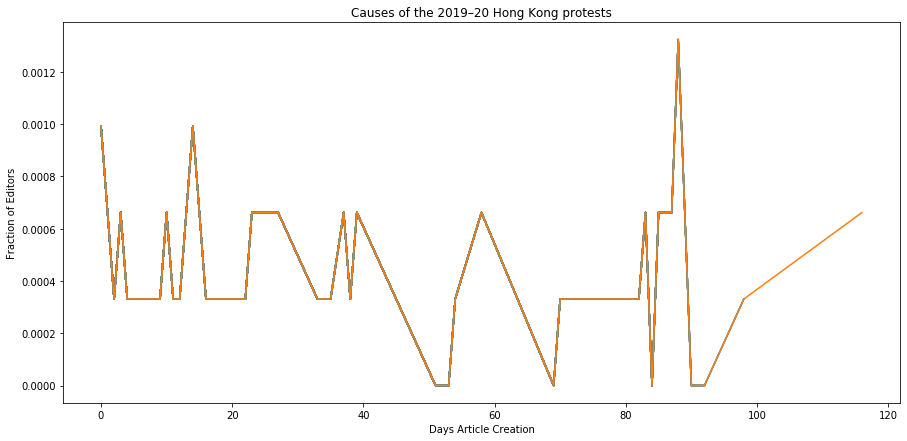

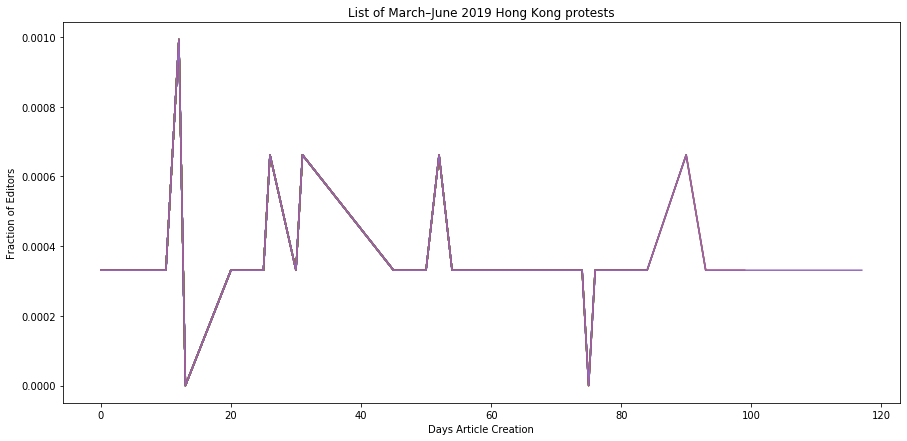

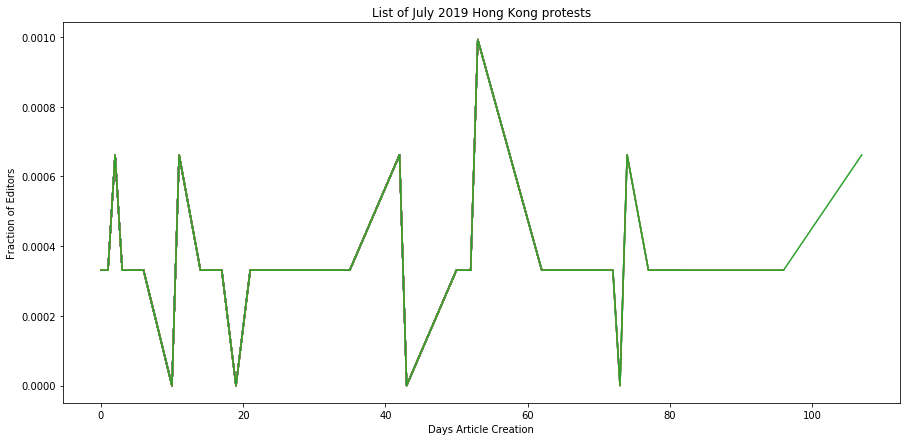

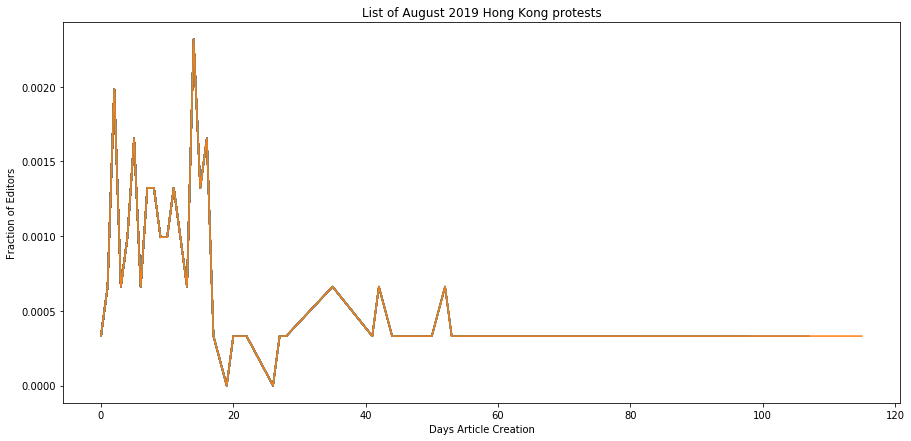

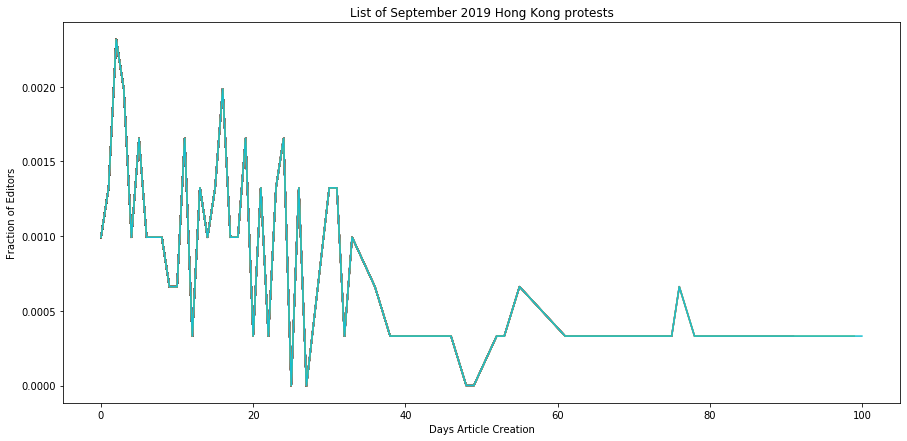

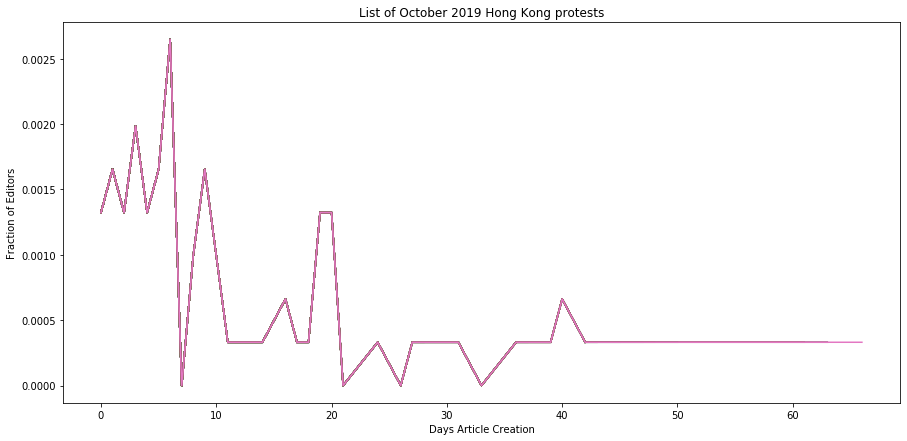

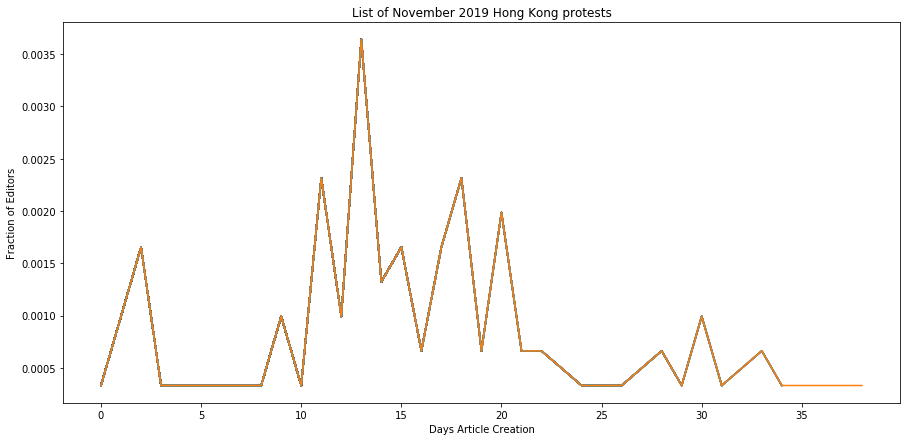

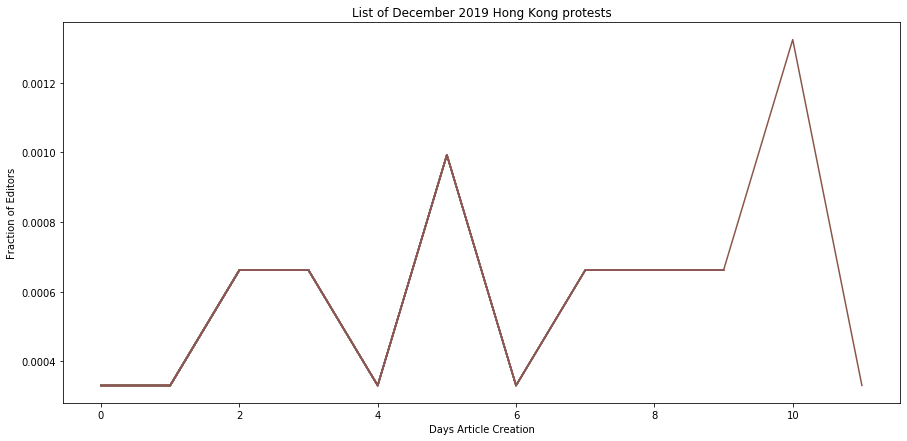

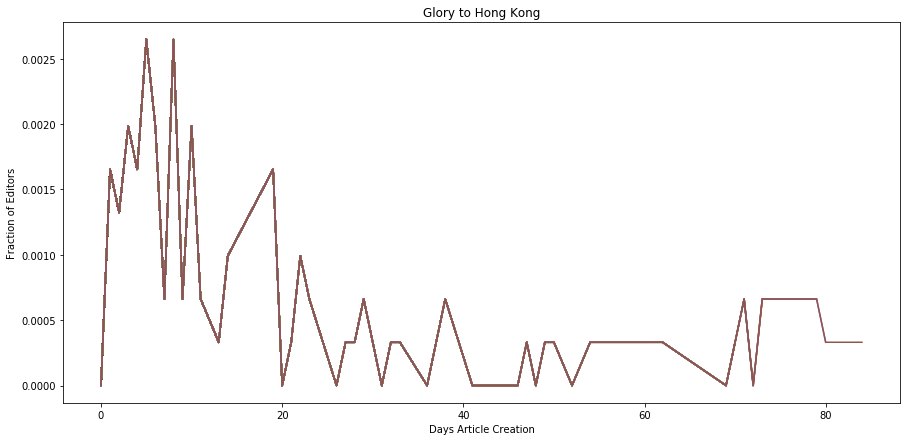

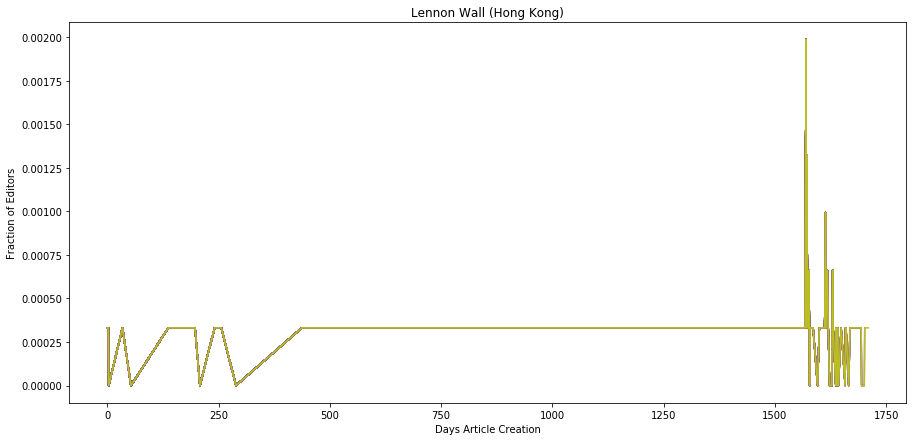

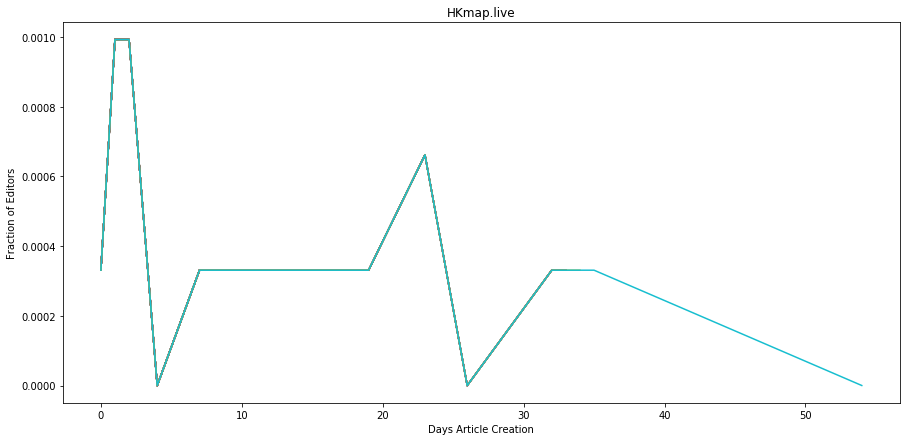

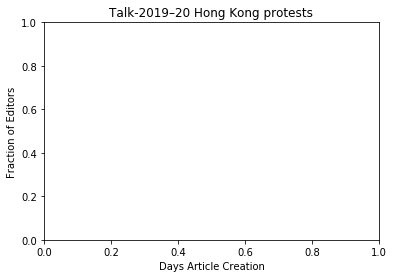

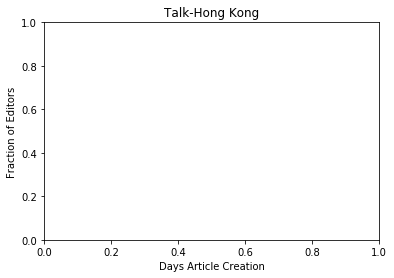

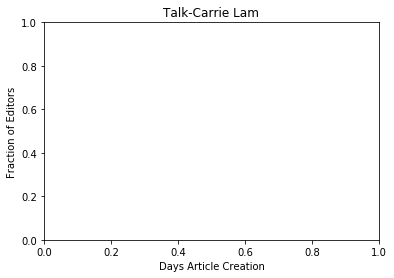

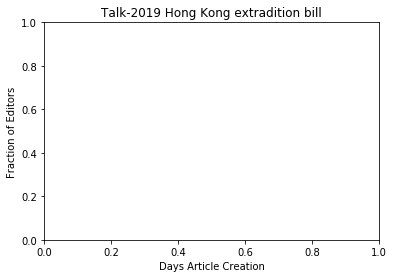

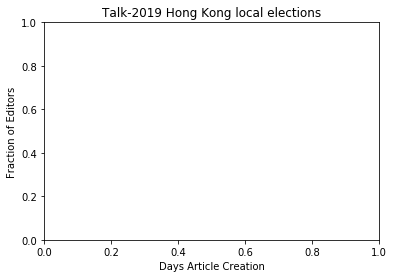

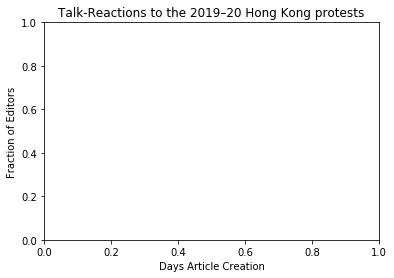

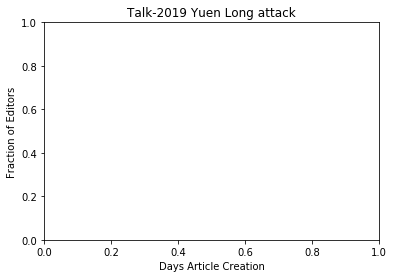

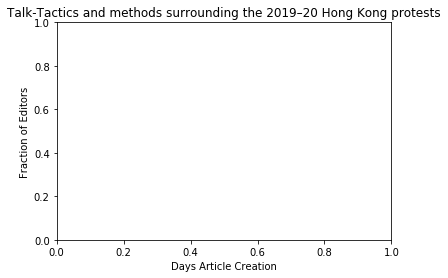

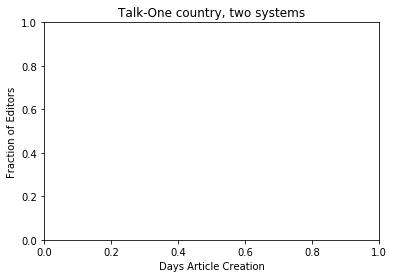

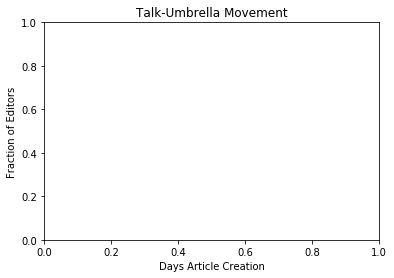

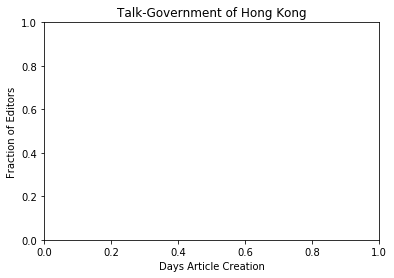

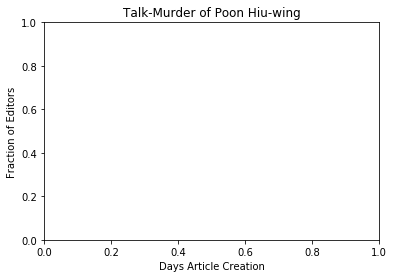

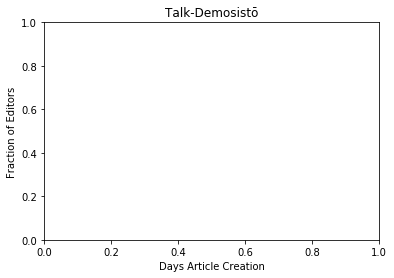

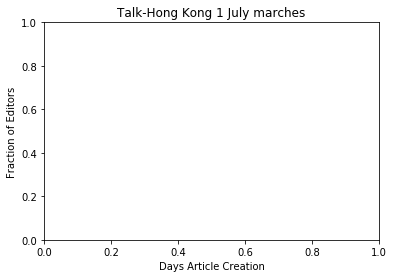

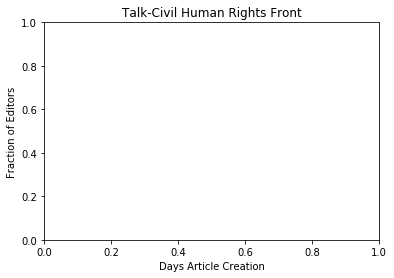

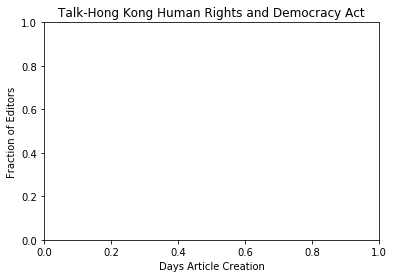

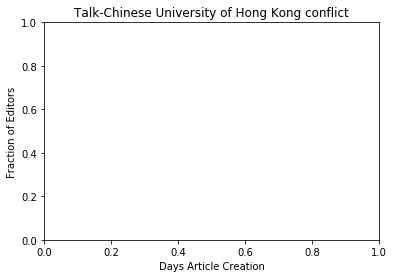

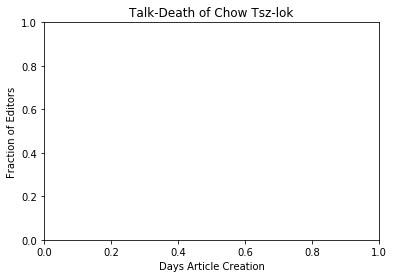

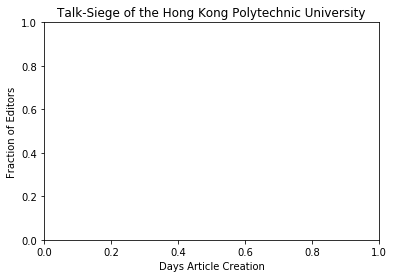

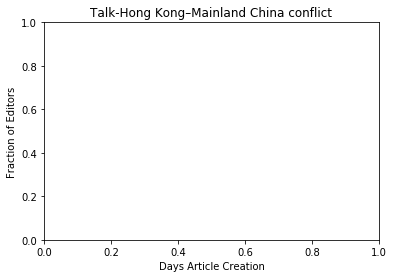

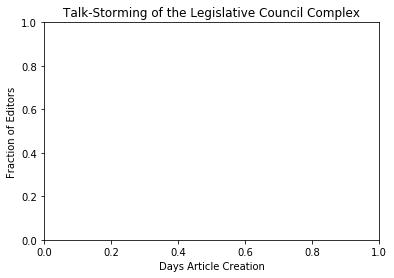

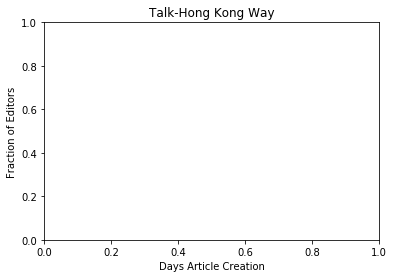

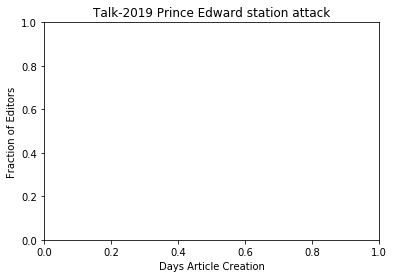

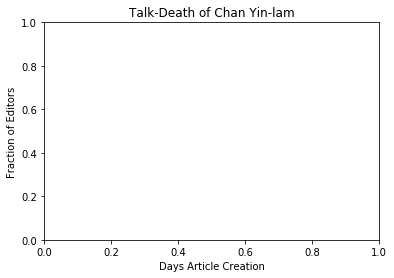

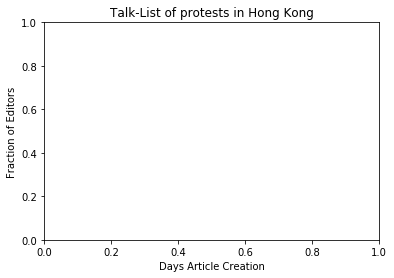

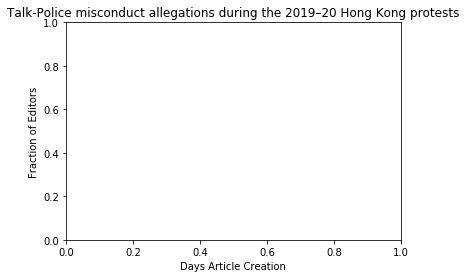

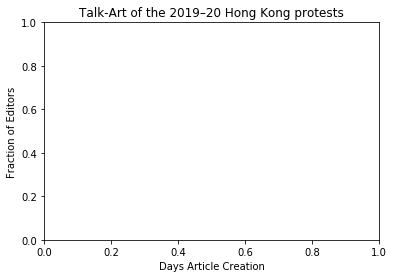

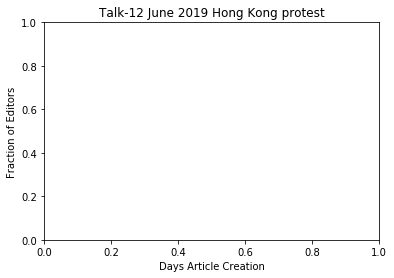

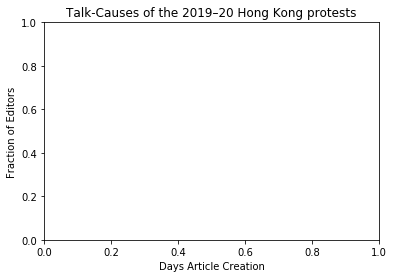

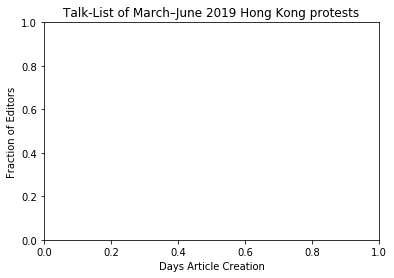

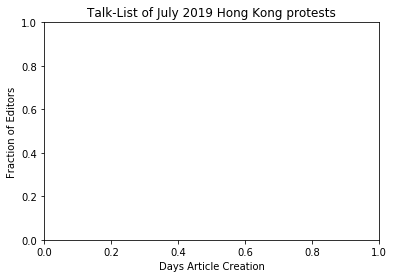

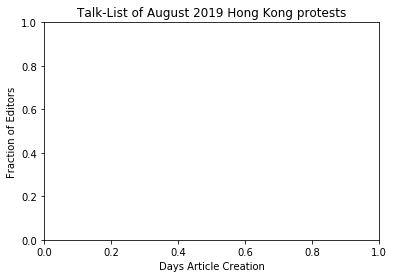

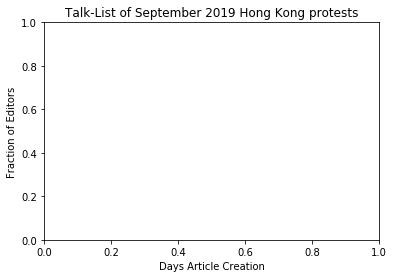

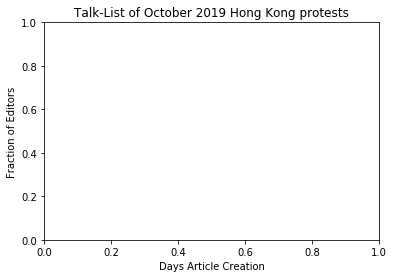

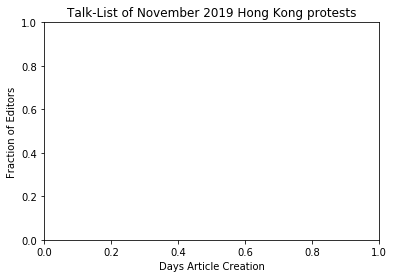

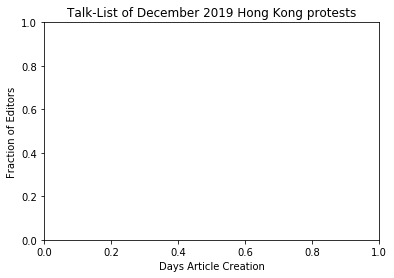

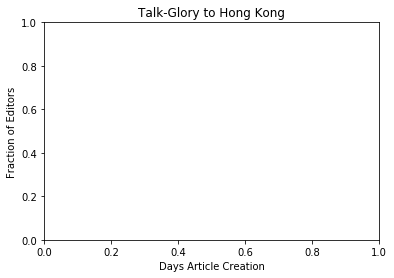

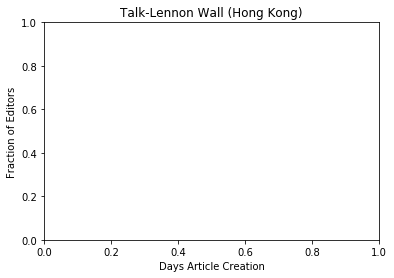

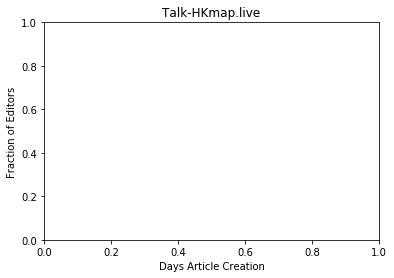

In [3]:
# Set to hold editors that edited on a given date
dailyEditorSet = set()
# Run through the non-top ten articles
for title in titleArray[11:]:
    key = title[:-4]
    if key[0:4] != "Talk":
        article = dataDict[key]
        sizeOfArticle = article.shape[0]
        newDate = dt.fromtimestamp(startDate)
        nextTimeDate = newDate.date()
        days = []
        editorFraction = []
        dayCount = 0
        prevEditTimeDate = startDate
        for day, editor in zip(article['timestamp'], article['user']):
            dayCount += 1
            editTime = dt.strptime(day, "%Y-%m-%dT%H:%M:%SZ")
            # Floor Date here
            editTimeDate = editTime.date()
            # While nextTimeDate does not equal the editTimeDate taken from the csv file, increment nextTimeDate
            # it is possible this will miss the very last one since it only adds to the list if newTimeDate goes 
            # beyond editTimeDate
            while(editTimeDate != nextTimeDate):
                newDate = newDate + timedelta(days=1)
                nextTimeDate = newDate.date()
                # if set is empty, don't add values
                if len(dailyEditorSet) != 0:
                    intersectionEditors = topTenEditorSet.intersection(dailyEditorSet)
                    fractionOfEditors = len(intersectionEditors) / len(topTenEditorSet)
                    editorFraction.append(fractionOfEditors)
                    dayDiff = prevEditTimeDate - startDateDict[key]
                    #print(prevEditTimeDate, "Start: ", startDateDict[key])
                    dayDiff = dayDiff.total_seconds() / 86400
                    days.append(dayDiff)
                    dailyEditorSet.clear()
                    
            prevEditTimeDate = editTimeDate        
            dailyEditorSet.add(editor)
            # Not an elegant way to handle edge case of last editTimeDate from csv file
            if dayCount == sizeOfArticle:
                intersectionEditors = topTenEditorSet.intersection(dailyEditorSet)
                fractionOfEditors = len(intersectionEditors) / len(topTenEditorSet)
                editorFraction.append(fractionOfEditors)
                dayDiff = prevEditTimeDate - startDateDict[key]
                #print(editTimeDate, "Start: ", startDateDict[key])
                dayDiff = dayDiff.total_seconds() / 86400
                days.append(dayDiff)
                dailyEditorSet.clear()
    
            plt.plot(days, editorFraction)
            plt.gcf().set_size_inches(15,7)

    plt.title(key)
    #plt.suptitle("10 year aggregate data. Shows number of edits per week in 6 month intervals.")
    plt.xlabel("Days Article Creation")
    plt.ylabel("Fraction of Editors")

#     ax = plt.subplot(111)
#     box = ax.get_position()
#     ax.set_position([box.x0, box.y0, box.width * 0.5, box.height])
    #plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    # Need to add subpath so that its easier to change which directory being used
    if (not os.path.isfile(os.path.join(plotPath, key + ".png"))):
        plt.savefig(os.path.join(plotPath, key + ".png"), bbox_inches="tight")
    plt.close()